In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

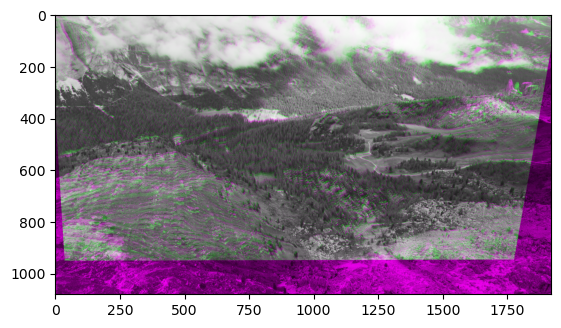

In [2]:
im1_path, im2_path = "input/test1.png", "input/test2.png"

im1 = cv2.cvtColor(cv2.imread(im1_path), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(im2_path), cv2.COLOR_BGR2RGB)


gray1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
sift = cv2.SIFT_create(nfeatures=2000)
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# use bf matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
mask = mask.squeeze().astype(bool)

# plot matches
# im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, good_matches, None)
# plt.imshow(im_matches)
# plt.show()

gray_warped = cv2.warpPerspective(gray1, H, (gray2.shape[1], gray2.shape[0]))

# plot warped image
im = np.stack([gray2, gray_warped, gray2], axis=-1)
plt.imshow(im)
plt.show()

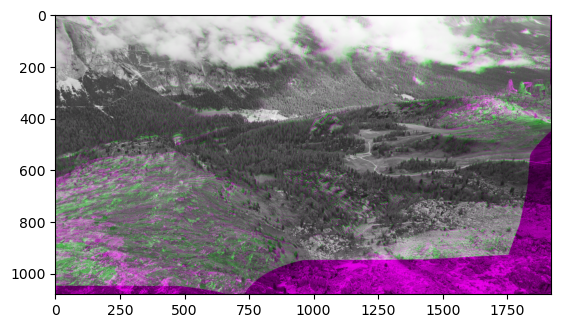

In [3]:
from time import time

class SmoothWarp:
    def __init__(self, im_size, nx=5, ny = 5, w_smooth=0.1, w_rot=0.1):
        self.imx = im_size[1]
        self.imy = im_size[0]
        self.nx = nx
        self.ny = ny
        self.w_smooth = w_smooth
        self.w_rot = w_rot
        self.transforms = np.zeros((ny, nx, 4))
        self.transforms[:, :, 0] = 1
        
    def warp(self, image):
        Nx = 100
        Ny = 100
        dnx = (Nx-3)
        dx = (self.imx-1)
        dny = (Nx-3)
        dy = (self.imy-1)

        x_ = np.linspace(-dx/dnx, dx + dx/dnx, Nx)
        y_ = np.linspace(-dy/dny, dy + dy/dny, Ny)
        
        x_grid, y_grid = np.meshgrid(x_, y_)
        
        wx = x_grid / self.imx * self.nx
        wy = y_grid / self.imy * self.ny

        ix = np.clip(np.floor(wx).astype(int), 0, self.nx-2)
        iy = np.clip(np.floor(wy).astype(int), 0, self.ny-2)

        wx -= ix
        wy -= iy

        w00 = (1 - wx) * (1 - wy)
        w01 = wx * (1 - wy)
        w10 = (1 - wx) * wy
        w11 = wx * wy

        t00 = self.transforms[iy, ix]
        t01 = self.transforms[iy, ix+1]
        t10 = self.transforms[iy+1, ix]
        t11 = self.transforms[iy+1, ix+1]

        coefs = (w00[..., None] * t00 + w01[..., None] * t01 +
                 w10[..., None] * t10 + w11[..., None] * t11)

        pt_in = np.stack([x_grid, y_grid, np.ones_like(x_grid)], axis=-1)
        
        transform = np.zeros((Ny, Nx, 2, 3))
        transform[..., 0, 0] = coefs[..., 0]
        transform[..., 0, 1] = coefs[..., 1]
        transform[..., 0, 2] = coefs[..., 2]
        transform[..., 1, 0] = -coefs[..., 1]
        transform[..., 1, 1] = coefs[..., 0]
        transform[..., 1, 2] = coefs[..., 3]
        
        pts_out = np.einsum('...ij,...j->...i', transform, pt_in)
        
        xs = np.linspace(1, Nx-2, self.imx, dtype = np.float32)
        ys = np.linspace(1, Ny-2, self.imy, dtype = np.float32)
        xx, yy = np.meshgrid(xs, ys)
        coords_out = cv2.remap(pts_out, xx, yy, interpolation=cv2.INTER_LINEAR)
        image_out = cv2.remap(image, coords_out.astype(np.float32), None, cv2.INTER_CUBIC)
        return image_out
    
    def calculate_indices_weights(self, src):
        x = src[:, 0]
        y = src[:, 1]

        wx = x / self.imx * self.nx
        wy = y / self.imy * self.ny

        ix = np.clip(np.floor(wx).astype(int), 0, self.nx-2)
        iy = np.clip(np.floor(wy).astype(int), 0, self.ny-2)

        wx -= ix
        wy -= iy

        w00 = (1 - wx) * (1 - wy)
        w01 = wx * (1 - wy)
        w10 = (1 - wx) * wy
        w11 = wx * wy

        return ix, iy, w00, w01, w10, w11

    def solve(self, src, dst):
        N = src.shape[0]
        Nh = sw.nx * sw.ny * 4
        H = np.zeros((Nh, Nh))
        v = np.zeros(Nh)
        for n in range(N):
            ix, iy, w00, w01, w10, w11 = sw.calculate_indices_weights(src[n,:].reshape(1,2))
            w_block = np.array([w00, w01, w10, w11])
            ind0 = sw.nx * iy + ix
            ind1 = (4*np.array([ind0, ind0+1, ind0+sw.nx, ind0+sw.nx+1]) + np.arange(4)).flatten()
            x, y = src[n,0], src[n,1]
            J_block1 = np.stack([np.array([x, y, 1, 0]), np.array([y, -x, 0, 1])], axis=-1)
            J_block = np.kron(w_block, J_block1)
            r_block = dst[n, :] 
            H_block = J_block @ J_block.T
            v_block = J_block @ r_block.T
            H[np.ix_(ind1, ind1)] += H_block
            v[ind1] += v_block

        H /= N
        v /= N

        J_reg = np.kron(np.array([1,-1]), np.eye(4))
        H_reg = J_reg.T @ J_reg
        for i in range(sw.nx):
            for j in range(sw.ny):
                ind0 = sw.nx * j + i
                if i > 0:
                    ind1 = (4*np.array([ind0, ind0-1]).reshape(-1,1) + np.arange(4).reshape(1,-1)).flatten()
                    H[np.ix_(ind1, ind1)] += sw.w_smooth * H_reg
                if j > 0:
                    ind1 = (4*np.array([ind0, ind0-sw.nx]).reshape(-1,1) + np.arange(4).reshape(1,-1)).flatten()
                    H[np.ix_(ind1, ind1)] += sw.w_smooth * H_reg
                
                ind1 = 4*ind0 + np.arange(2)
                J_rot = np.eye(2)
                r_rot = np.array([1, 0])
                H_rot = J_rot @ J_rot.T
                v_rot = J_rot @ r_rot.T
                H[np.ix_(ind1, ind1)] += self.w_rot * H_rot
                v[ind1] += self.w_rot * v_rot
    
        res = np.linalg.solve(H, v)
        self.transforms = res.reshape(self.ny, self.nx, 4)
        
    
sw = SmoothWarp(gray2.shape, nx=8, ny=8, w_smooth=0.001, w_rot=0.1)
sw.solve(dst_pts[mask], src_pts[mask])
gray_warped_smooth = sw.warp(gray1)
im = np.stack([gray2, gray_warped_smooth, gray2], axis=-1)
plt.imshow(im, cmap='gray')
plt.show()
        

In [151]:
mask.shape

(647,)

In [89]:
sw.calculate_indices_weights(np.array([[0,0]]))

(array([0]), array([0]), array([1.]), array([0.]), array([0.]), array([0.]))

In [105]:
src = np.random.rand(1000, 2) * np.array([gray1.shape[1], gray1.shape[0]])
t = np.random.randn(4) * np.array([0.5,0.5,30,30]) + np.array([1, 0, 0, 0])
A = np.array([[t[0], t[1], t[2]], [-t[1], t[0], t[3]]])
dst = (A @ np.concatenate([src.T, np.ones((1, src.shape[0]))], axis=0)).T

In [131]:
t

array([  1.77587251,   0.10754149,  45.87210856, -30.19280875])

In [132]:
N = src.shape[0]
Nh = sw.nx * sw.ny * 4
H = np.zeros((Nh, Nh))
v = np.zeros(Nh)
for n in range(N):
    ix, iy, w00, w01, w10, w11 = sw.calculate_indices_weights(src[n,:].reshape(1,2))
    w_block = np.array([w00, w01, w10, w11])
    # w_block = np.array([0.25,0.25,0.25,0.25]).reshape(4,1)
    ind0 = sw.nx * iy + ix
    ind1 = (4*np.array([ind0, ind0+1, ind0+sw.nx, ind0+sw.nx+1]) + np.arange(4)).flatten()
    x, y = src[n,0], src[n,1]
    J_block1 = np.stack([np.array([x, y, 1, 0]), np.array([y, -x, 0, 1])], axis=-1)
    J_block = np.kron(w_block, J_block1)
    r_block = dst[n, :] 
    H_block = J_block @ J_block.T
    v_block = J_block @ r_block.T
    H[np.ix_(ind1, ind1)] += H_block
    v[ind1] += v_block

J_reg = np.kron(np.array([1,-1]), np.eye(4))
H_reg = J_reg.T @ J_reg
for i in range(sw.nx):
    for j in range(sw.ny):
        ind0 = sw.nx * j + i
        if i > 0:
            ind1 = (4*np.array([ind0, ind0-1]).reshape(-1,1) + np.arange(4).reshape(1,-1)).flatten()
            H[np.ix_(ind1, ind1)] += sw.w_smooth * H_reg
        if j > 0:
            ind1 = (4*np.array([ind0, ind0-sw.nx]).reshape(-1,1) + np.arange(4).reshape(1,-1)).flatten()
            H[np.ix_(ind1, ind1)] += sw.w_smooth * H_reg
     
      
res = np.linalg.solve(H, v)

In [133]:
res

array([  1.77587251,   0.10754149,  45.87210856, -30.19280874,
         1.77587251,   0.10754149,  45.87210862, -30.19280876,
         1.77587251,   0.10754149,  45.87210857, -30.19280871,
         1.77587251,   0.10754149,  45.87210863, -30.19280872])

In [112]:
J_block1

array([[ 135.78743772,  229.96813468],
       [ 229.96813468, -135.78743772],
       [   1.        ,    0.        ],
       [   0.        ,    1.        ]])

In [118]:
w_block.shape

(4, 1)

In [114]:
J_block

array([[ 6.69329803e+01,  1.13356971e+02],
       [ 1.13356971e+02, -6.69329803e+01],
       [ 4.92924688e-01,  0.00000000e+00],
       [ 0.00000000e+00,  4.92924688e-01],
       [ 1.10270800e+01,  1.86753434e+01],
       [ 1.86753434e+01, -1.10270800e+01],
       [ 8.12083962e-02,  0.00000000e+00],
       [ 0.00000000e+00,  8.12083962e-02],
       [ 4.96479696e+01,  8.40832640e+01],
       [ 8.40832640e+01, -4.96479696e+01],
       [ 3.65630065e-01,  0.00000000e+00],
       [ 0.00000000e+00,  3.65630065e-01],
       [ 8.17940771e+00,  1.38525564e+01],
       [ 1.38525564e+01, -8.17940771e+00],
       [ 6.02368514e-02,  0.00000000e+00],
       [ 0.00000000e+00,  6.02368514e-02]])

In [64]:
ind1 = 4*np.array([ind0, ind0+1, ind0+sw.nx, ind0+sw.nx+1])

In [102]:
a = np.array([1, 2, 3, 4])
w = np.array([0.1, 1, 10, 100])

np.kron(w,a).reshape(1,-1)

array([[1.e-01, 2.e-01, 3.e-01, 4.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00,
        1.e+01, 2.e+01, 3.e+01, 4.e+01, 1.e+02, 2.e+02, 3.e+02, 4.e+02]])

In [79]:
np.array([ind0, ind0+1, ind0+sw.nx, ind0+sw.nx+1]).shape

(4, 1)

In [82]:
v_block

array([ 2.60381375e+05,  3.81687985e+03,  5.92927230e+05,  8.69160475e+03,
        1.86022021e+05,  2.72686057e+03,  4.23599890e+05,  6.20946826e+03,
        2.41715541e+02,  3.54326102e+00,  5.50422340e+02,  8.06853385e+00,
       -1.29362418e+02, -1.89629849e+00, -2.94577522e+02, -4.31815451e+00])

In [67]:
H = np.zeros((5,5))
H[[0,2],[1,3]]=1
H

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [46]:
w_block

array([[0.30073485, 0.00440841, 0.68481812, 0.01003862]])

In [ ]:

ix, iy, w00, w01, w10, w11 = self.calculate_indices_weights(src)
indices = [self.nx*iy + ix, self.nx*iy + ix+1, self.nx*(iy+1) + ix, self.nx*(iy+1) + ix+1]
weights = np.array([w00, w01, w10, w11]).reshape(1,-1)
n = src.shape[0]
I = np.ones(n)
O = np.zeros(n)
A = np.hstack([np.vstack([src[:,0],  src[:,1], I, O]),
               np.vstack([src[:,1], -src[:,0], O, I])])

B = np.hstack([dst[:,0], dst[:,1]])

In [71]:


imx = gray2.shape[1]
imy = gray2.shape[0]

nx = 10
ny = 10

x = np.linspace(-nx/imx, imx+ nx/imx, 100)

k = (ny-1)/(imy-1)
k2 = ny/imy
k3 = imy/ny
k4 = ny - 1

y = np.linspace(ny-2, imy - ny + 1, ny)

xx, yy = np.meshgrid(x, y)

coords = np.stack([xx, yy], axis=-1)
coords_out = cv2.resize(coords, (imx, imy), interpolation=cv2.INTER_LINEAR, 

print(coords_out[:3,0,1])
print(coords_out[-3:,0,1])



# coords = cv2.resize(pts_out, (self.imx, self.imy), interpolation=cv2.INTER_CUBIC)

[8. 8. 8.]
[1071. 1071. 1071.]


In [118]:

imx = gray2.shape[1]
imy = gray2.shape[0]

nx = 10
ny = 10

dnx = (nx-3)
dx = (imx-1)
dny = (ny-3)
dy = (imy-1)

x = np.linspace(-dx/dnx, dx + dx/dnx, nx)
y = np.linspace(-dy/dny, dy + dy/dny, ny)

xx, yy = np.meshgrid(x, y)
coords_in = np.stack([xx, yy], axis=-1)


xs = np.linspace(1, nx-2, imx, dtype = np.float32)
ys = np.linspace(1, ny-2, imy, dtype = np.float32)
xx, yy = np.meshgrid(xs, ys)
coords_out = cv2.remap(coords_in, xx, yy, interpolation=cv2.INTER_LINEAR)
print(coords_out[0,0,1],coords_out[-1,0,1])



0.0 1079.0


In [96]:
coords

array([[[-192., -108.],
        [  64., -108.],
        [ 320., -108.],
        [ 576., -108.],
        [ 832., -108.],
        [1088., -108.],
        [1344., -108.],
        [1600., -108.],
        [1856., -108.],
        [2112., -108.]],

       [[-192.,   36.],
        [  64.,   36.],
        [ 320.,   36.],
        [ 576.,   36.],
        [ 832.,   36.],
        [1088.,   36.],
        [1344.,   36.],
        [1600.,   36.],
        [1856.,   36.],
        [2112.,   36.]],

       [[-192.,  180.],
        [  64.,  180.],
        [ 320.,  180.],
        [ 576.,  180.],
        [ 832.,  180.],
        [1088.,  180.],
        [1344.,  180.],
        [1600.,  180.],
        [1856.,  180.],
        [2112.,  180.]],

       [[-192.,  324.],
        [  64.,  324.],
        [ 320.,  324.],
        [ 576.,  324.],
        [ 832.,  324.],
        [1088.,  324.],
        [1344.,  324.],
        [1600.,  324.],
        [1856.,  324.],
        [2112.,  324.]],

       [[-192.,  468.],
        

In [18]:
import numpy as np

def calculate_original_points(target_size, grid_size):
    target_height, target_width = target_size
    original_height, original_width = grid_size
    
    # Calculate scaling factors
    scale_x = (target_width - 1) / (original_width - 1)
    scale_y = (target_height - 1) / (original_height - 1)
    
    # Centers
    x_original_center = (original_width - 1) / 2
    y_original_center = (original_height - 1) / 2
    x_scaled_center = (target_width - 1) / 2
    y_scaled_center = (target_height - 1) / 2
    
    # Original grid points calculation
    x_scaled = np.linspace(0, target_width - 1, target_width)
    y_scaled = np.linspace(0, target_height - 1, target_height)
    
    x_original = (x_scaled - x_scaled_center) / scale_x + x_original_center
    y_original = (y_scaled - y_scaled_center) / scale_y + y_original_center
    
    return x_original, y_original

# Define the target size and original grid size
target_size = (1080, 1920)
grid_size = (100, 100)

x_original, y_original = calculate_original_points(target_size, grid_size)

# Print the first few and last few points to verify
print("Original X coordinates:\n", x_original[:5], "...", x_original[-5:])
print("Original Y coordinates:\n", y_original[:5], "...", y_original[-5:])

Original X coordinates:
 [0.         0.05158937 0.10317874 0.15476811 0.20635748] ... [98.79364252 98.84523189 98.89682126 98.94841063 99.        ]
Original Y coordinates:
 [0.         0.09175162 0.18350324 0.27525487 0.36700649] ... [98.63299351 98.72474513 98.81649676 98.90824838 99.        ]


In [3]:
pts = np.random.rand(10, 2)
t = np.random.rand(4)
gt_tform = np.array([[t[0], t[1], t[2]], [-t[1], t[0], t[3]]])
pts_out = (gt_tform @ np.concatenate([pts.T, np.ones((1, pts.shape[0]))], axis=0)).T

In [4]:
pts_out.shape

(10, 2)

In [5]:
A, mask = cv2.estimateAffine2D(pts, pts_out)

In [6]:
A

array([[ 0.42172026,  0.29885013,  0.31295744],
       [-0.29885013,  0.42172025,  0.7159993 ]])

In [7]:
gt_tform

array([[ 0.42172025,  0.29885014,  0.31295745],
       [-0.29885014,  0.42172025,  0.71599931]])

In [15]:
n = 10
I = np.ones(n)
O = np.zeros(n)
A = np.hstack([np.vstack([pts[:,0],  pts[:,1], I, O]),
               np.vstack([pts[:,1], -pts[:,0], O, I])])

B = np.hstack([pts_out[:,0], pts_out[:,1]])

coefs = np.linalg.lstsq(A.T, B, rcond=None)[0]
coefs

array([0.42172025, 0.29885014, 0.31295745, 0.71599931])

In [14]:
B.shape

(20,)

In [19]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([ 0.1, 0.2, 0.3]).reshape(-1, 1)

# hadamard product
np.kron(a, b)

array([[0.1, 0.2, 0.3],
       [0.2, 0.4, 0.6],
       [0.3, 0.6, 0.9],
       [0.4, 0.5, 0.6],
       [0.8, 1. , 1.2],
       [1.2, 1.5, 1.8]])